In [2]:
#Import libraries
os.chdir("/home/robbe/ionbot/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import os
from pathlib import Path
from pyteomics import mass as pymass
import OxiAnalysis as OA
import importlib
importlib.reload(OA)
import warnings; warnings.simplefilter('ignore')

Goal here: make a fingerprint of delta masses for control vs treatment and then subtract control fingerprint from treatment fingerprint

# PXD022545

## Intensity based

### Calculations

In [3]:
cols = ['Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02',
       'Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03']

In [4]:
PXD022545 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD022545/mzml_files/QuantifiedPeptides.tsv", sep="\t")
PXD022545.drop(list(PXD022545.filter(regex = 'Detection Type')), axis = 1, inplace = True)

In [5]:
OA.quantile_transform(PXD022545, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03,Unnamed: 17
0,AAAAAAAAAVSRnan,AAAAAAAAAVSR,ZFP91_HUMAN,NaN,NaN,3.740595,3.598344,NaN,NaN,NaN,NaN,NaN
1,AAAAAAAGDSDSWDADAFSVEDPVRK12|[5]Carbamyl[S],AAAAAAAGDSDSWDADAFSVEDPVRK,EIF3J_HUMAN,NaN,NaN,3.723749,NaN,3.576714,3.944165,4.111965,3.891135,NaN
2,AAAAAAALQAKnan,AAAAAAALQAK,RL4_HUMAN,NaN,NaN,6.375439,6.044869,6.736737,6.285343,6.014918,6.635242,NaN
3,AAAAADGPPAADGEDGQDPHSK4|semi_tryptic,AAAAADGPPAADGEDGQDPHSK,TXND5_HUMAN,NaN,NaN,4.128794,4.581340,3.772819,4.168019,3.019854,3.029497,NaN
4,AAAAADLANRnan,AAAAADLANR,NaN,NaN,NaN,3.878141,4.508245,4.170794,4.567799,4.356829,4.339505,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
34439,YYTVFDRDNNRnan,YYTVFDRDNNR,CATD_HUMAN,NaN,NaN,NaN,5.404300,2.890858,6.041208,6.183599,6.076473,NaN
34440,YYTVFDRnan,YYTVFDR,CATD_HUMAN,NaN,NaN,6.515225,6.691287,6.657141,6.778519,6.628037,6.704846,NaN
34441,YYVTIIDAPGHRDFIKnan,YYVTIIDAPGHRDFIK,NaN,NaN,NaN,5.279995,5.535589,5.930679,4.855595,2.695792,5.796090,NaN
34442,YYVTIIDAPGHRnan,YYVTIIDAPGHR,NaN,NaN,NaN,6.745909,6.832146,7.084362,6.632395,6.365648,7.128726,NaN


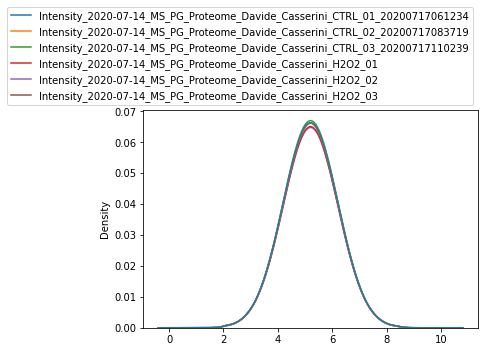

In [6]:
ax = sns.kdeplot(data=PXD022545[cols])
sns.move_legend(ax, "lower right", bbox_to_anchor=(1, 1))

In [7]:
db = pymass.Unimod()

In [8]:
def modifications(seq):
    if seq.endswith("nan"):
        return None
    else:
        pattern = re.compile(pattern=r"\[(\d+)\]")
        matches = re.findall(pattern, seq)
        if matches != None:
            for i in matches:
                return [i for i in matches]
                
def get_delta_mass(seq):
    
    if seq.endswith("nan"):
        return 0
    else:
        pattern = re.compile(pattern=r"\[(\d+)\]")
        matches = re.findall(pattern, seq)
        if matches != None:
            delta_mass = 0
            for i in matches:
                    for p in range(len(db.mods)):
                        if db.mods[p]['record_id'] == float(i):
                
                            mm = db.mods[p]['mono_mass']
                            # mm = db.mods[p]['delta_mono_mass']
                            delta_mass += mm
            return delta_mass
        else:
            return 0
                    

                

In [9]:
PXD022545["Modifications"] = PXD022545["Sequence"].apply(modifications)
PXD022545["Delta_mass"] = PXD022545["Sequence"].apply(get_delta_mass)

In [10]:
No_zero = PXD022545[PXD022545["Delta_mass"] != 0]

In [11]:
# g = No_zero.groupby("Delta_mass").median().reset_index()
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [12]:

from statistics import median


g['medianCtrl']=g.apply(lambda x:median([x[c] for c in g.columns if "CTRL" in c]),axis=1)
g["medianH2O2"]=g.apply(lambda x:median([x[c] for c in g.columns if "H2O2" in c]), axis=1)
# g['Quotient']=(g["medianH2O2"] - g["medianCtrl"]) / max([g["medianCtrl"], g["medianH2O2"]])
# g["Quotient"] = ((g["medianH2O2"] - g["medianCtrl"])/ g["medianCtrl"]).where( g["medianCtrl"] >= g["medianH2O2"], other=(g["medianH2O2"] - g["medianCtrl"])/ g["medianH2O2"])
# g["Quotient"] = ((g["medianH2O2"] - g["medianCtrl"])/ g["medianH2O2"]).where( g["medianCtrl"] < g["medianH2O2"])
g["Difference"] = (g["medianH2O2"] - g["medianCtrl"])

In [13]:
# gfiltered = g[(g["medianCtrl"] !=0) & (g["medianH2O2"] !=0) ]


### Plots

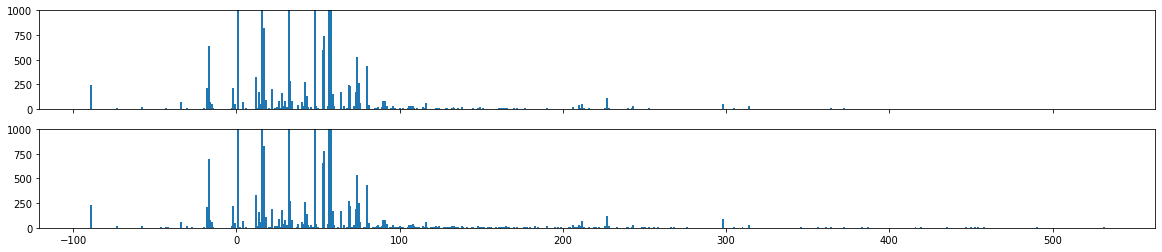

In [14]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=g.Delta_mass, height=g.medianH2O2, width=1.2)
ax2.bar(x=g.Delta_mass, height=g.medianCtrl, width=1.2)

fig.set_size_inches(20,4)
plt.ylim(0,1000)
plt.show()

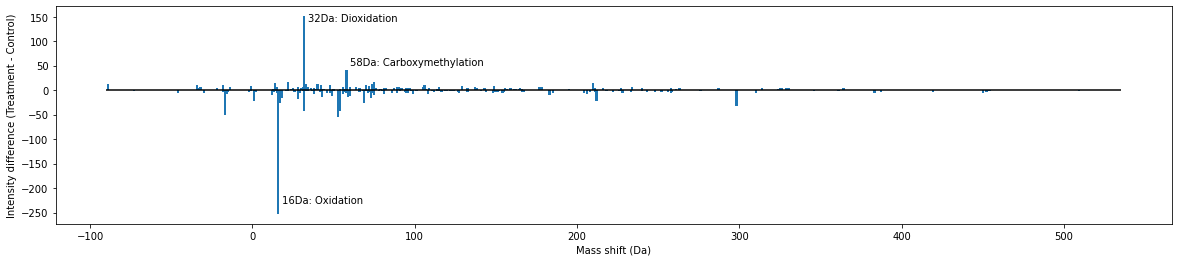

In [34]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.Difference, width=1.4)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=535, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (Treatment - Control)")
# plt.ylim(0,7000)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.text(x= 18, y= -230, s= "16Da: Oxidation")
plt.text(x=34, y= 140, s="32Da: Dioxidation")
plt.text(x=60, y=50, s= "58Da: Carboxymethylation")
plt.show()

In [16]:
# gfiltered["Quotient"].replace(np.inf, np.nan, inplace=True)
# gfiltered["Quotient"].replace(np.nan, 0, inplace=True)
sorted = g.sort_values(by="Difference", axis=0, ascending=False)

In [17]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03,Unnamed: 17,medianCtrl,medianH2O2,Difference
92,31.989830,0.0,0.0,3096.229437,3078.005166,2987.418387,3286.448957,3133.528041,3228.908100,0.0,3078.005166,3228.908100,150.902934
163,58.005479,0.0,0.0,2583.320420,2560.794002,2504.144629,2396.325731,2603.197761,2602.750968,0.0,2560.794002,2602.750968,41.956966
69,21.981943,0.0,0.0,183.302340,189.578315,185.559413,202.998095,205.414020,194.412773,0.0,185.559413,202.998095,17.438682
208,75.012042,0.0,0.0,260.494523,249.438439,230.532794,263.339422,265.962289,277.982616,0.0,249.438439,265.962289,16.523850
490,210.002050,0.0,0.0,41.150673,24.366227,26.132506,32.182421,41.324235,41.665996,0.0,26.132506,41.324235,15.191730
51,14.015650,0.0,0.0,149.417485,165.846468,160.543906,190.584247,174.796446,163.750466,0.0,160.543906,174.796446,14.252540
204,74.000395,0.0,0.0,85.943853,104.806158,96.098434,113.135148,108.892579,109.612701,0.0,96.098434,109.612701,13.514267
113,40.031300,0.0,0.0,77.469745,53.058226,55.455605,60.363176,82.647070,68.926284,0.0,55.455605,68.926284,13.470680
94,33.021464,0.0,0.0,275.144042,275.209269,260.092196,288.564972,291.514835,278.250639,0.0,275.144042,288.564972,13.420929
0,-89.029920,0.0,0.0,227.494646,231.353964,210.970823,243.863275,239.958737,237.530828,0.0,227.494646,239.958737,12.464092


31.989830: Two Oxidations!

58.005479: Carboxymethyl!


(21.981943: Sodium adduct

75.012042: Fluoro + Carbamidomethylation

210.002050: CarboxymethylDTT

14.015650: Methylation

74.000395: Oxidation + Carboxymethylation

40.031300: Propionaldehyde adduct

33.021464: Ammonium + Oxidation

-89.029920: Loss of methionine + acetylation of new N-term
)


In [18]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_01_20200717061234,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_02_20200717083719,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_CTRL_03_20200717110239,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_01,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_02,Intensity_2020-07-14_MS_PG_Proteome_Davide_Casserini_H2O2_03,Unnamed: 17,medianCtrl,medianH2O2,Difference
496,212.008590,0.0,0.0,74.708021,73.817250,68.801617,68.905554,50.788299,51.495410,0.0,73.817250,51.495410,-22.321840
36,0.984016,0.0,0.0,2300.541951,2372.890664,2378.515094,2350.543640,2428.747457,2348.650218,0.0,2372.890664,2350.543640,-22.347024
59,16.978931,0.0,0.0,772.551712,833.746744,831.391748,842.428152,791.962135,805.506375,0.0,831.391748,805.506375,-25.885373
189,68.906379,0.0,0.0,269.027438,272.019685,254.461072,256.884275,234.602586,242.269817,0.0,269.027438,242.269817,-26.757621
557,298.146347,0.0,0.0,87.589742,94.830760,84.101792,55.010143,57.645997,49.995559,0.0,87.589742,55.010143,-32.579599
148,53.919289,0.0,0.0,811.653745,780.311073,743.200576,788.010793,689.213365,738.497641,0.0,780.311073,738.497641,-41.813432
91,31.989829,0.0,0.0,964.117626,1093.043595,1137.066471,1089.497069,1049.396134,1000.269279,0.0,1093.043595,1049.396134,-43.647461
20,-17.026549,0.0,0.0,698.455579,669.552818,693.118247,647.520633,643.265704,641.254563,0.0,693.118247,643.265704,-49.852543
146,52.911464,0.0,0.0,675.444577,653.692365,617.062147,640.340352,572.657109,599.149866,0.0,653.692365,599.149866,-54.542500
58,15.994915,0.0,0.0,19089.132419,19063.495459,19523.605358,18836.254817,18769.190523,19286.184646,0.0,19089.132419,18836.254817,-252.877603


15.994915: Oxidation

52.911464: Replacement of 3 protons by iron	

-17.026549: Ammonium loss

31.989829: Dioxidation

53.919289: Replacement of 2 protons by iron

298.146347: biotin hydrazide labeled acrolein addition

68.906379: Oxidation + Replacement of 3 protons by iron

16.978931: Deamidated + Oxidation

0.984016: Deamidation

212.008590: Phosporibosylation





## PSM count

In [114]:
PXD022545_first = pd.read_csv("/home/robbe/ionbot/full_projects_/PXD022545/PXD022545_first.csv")
PXD022545_first.head()

,Unnamed: 0,ionbot_match_id,spectrum_title,scan,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,...,Organism,Cell line,Oxidant treatment,Oxidant dose (µM),Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting
0,0,0_8_1,controllerType=0 controllerNumber=1 scan=10,10,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,790.34769,790.34568,0.88133,2,EAADTER,...,Human,ARPE-19,None,0,None,0,0,0,NaN,First
1,1,0_7572_1,controllerType=0 controllerNumber=1 scan=10006,10006,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,1911.78352,1911.78054,1163.81700,4,SEEAHAEDSVMDHHFR,...,Human,ARPE-19,None,0,None,0,0,0,NaN,First
2,2,0_7573_4,controllerType=0 controllerNumber=1 scan=10007,10007,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,762.36667,762.36603,1163.86404,2,GTFPDAR,...,Human,ARPE-19,None,0,None,0,0,0,NaN,First
3,3,0_7574_2,controllerType=0 controllerNumber=1 scan=10008,10008,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,939.45005,939.44836,1163.91264,2,VMEYINR,...,Human,ARPE-19,None,0,None,0,0,0,NaN,First
4,4,0_7575_1,controllerType=0 controllerNumber=1 scan=10010,10010,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,895.40507,895.40354,1164.25452,2,ESFDGSVR,...,Human,ARPE-19,None,0,None,0,0,0,NaN,First


In [115]:
def get_delta_mass_first(str):
    dm = 0
    def splitatn(strng, sep, pos):
        strng = strng.split(sep)
        return sep.join(strng[:pos]), sep.join(strng[pos:])
    deltamasses = splitatn(str, "|", 2)
    for i in deltamasses:
        try:
            deltamass = i.split("|")[1]
            dm += float(deltamass)
        except (IndexError, ValueError):
            dm+=0
    return dm


In [116]:
PXD022545_first["delta_mass"] = PXD022545_first["modifications_delta"].apply(get_delta_mass_first)

In [117]:
PXD022545_first.head()

,Unnamed: 0,ionbot_match_id,spectrum_title,scan,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,...,Cell line,Oxidant treatment,Oxidant dose (µM),Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting,delta_mass
0,0,0_8_1,controllerType=0 controllerNumber=1 scan=10,10,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,790.34769,790.34568,0.88133,2,EAADTER,...,ARPE-19,None,0,None,0,0,0,NaN,First,0.0000
1,1,0_7572_1,controllerType=0 controllerNumber=1 scan=10006,10006,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,1911.78352,1911.78054,1163.81700,4,SEEAHAEDSVMDHHFR,...,ARPE-19,None,0,None,0,0,0,NaN,First,15.9949
2,2,0_7573_4,controllerType=0 controllerNumber=1 scan=10007,10007,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,762.36667,762.36603,1163.86404,2,GTFPDAR,...,ARPE-19,None,0,None,0,0,0,NaN,First,0.0000
3,3,0_7574_2,controllerType=0 controllerNumber=1 scan=10008,10008,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,939.45005,939.44836,1163.91264,2,VMEYINR,...,ARPE-19,None,0,None,0,0,0,NaN,First,15.9949
4,4,0_7575_1,controllerType=0 controllerNumber=1 scan=10010,10010,2020-07-14_MS_PG_Proteome_Davide_Casserini_CTR...,895.40507,895.40354,1164.25452,2,ESFDGSVR,...,ARPE-19,None,0,None,0,0,0,NaN,First,0.0000


In [118]:
g1 = PXD022545_first.groupby(["delta_mass", "spectrum_file"])["ionbot_match_id"].count().reset_index()

In [119]:
Ctrl = g1.loc[g1["spectrum_file"].str.contains("CTRL")]
H2O2 = g1.loc[g1["spectrum_file"].str.contains("H2O2")]

In [120]:
Ctrlmedian = Ctrl.groupby("delta_mass").median().reset_index()
H2O2median = H2O2.groupby("delta_mass").median().reset_index()

In [121]:
Ctrlmedian.rename(columns={"ionbot_match_id" : "PSM_count"}, inplace=True)
H2O2median.rename(columns={"ionbot_match_id" : "PSM_count"}, inplace=True)

In [122]:
data = pd.merge(Ctrlmedian, H2O2median, on=["delta_mass", "delta_mass"], how="outer", suffixes=["_Control", "_H2O2"])
data.replace(np.nan, 0, inplace=True)


In [123]:
data["PSM_count_Control"] = data["PSM_count_Control"] / 75716
data["PSM_count_H2O2"] = data["PSM_count_H2O2"] / 40070
# data["Difference"] = ((data["PSM_count_H2O2"] - data["PSM_count_Control"]) / data["PSM_count_Control"]).where(data["PSM_count_Control"]>= data["PSM_count_H2O2"], other=(data["PSM_count_H2O2"]-data["PSM_count_Control"])/ data["PSM_count_H2O2"])
data["Difference"] = (data["PSM_count_H2O2"] - data["PSM_count_Control"])

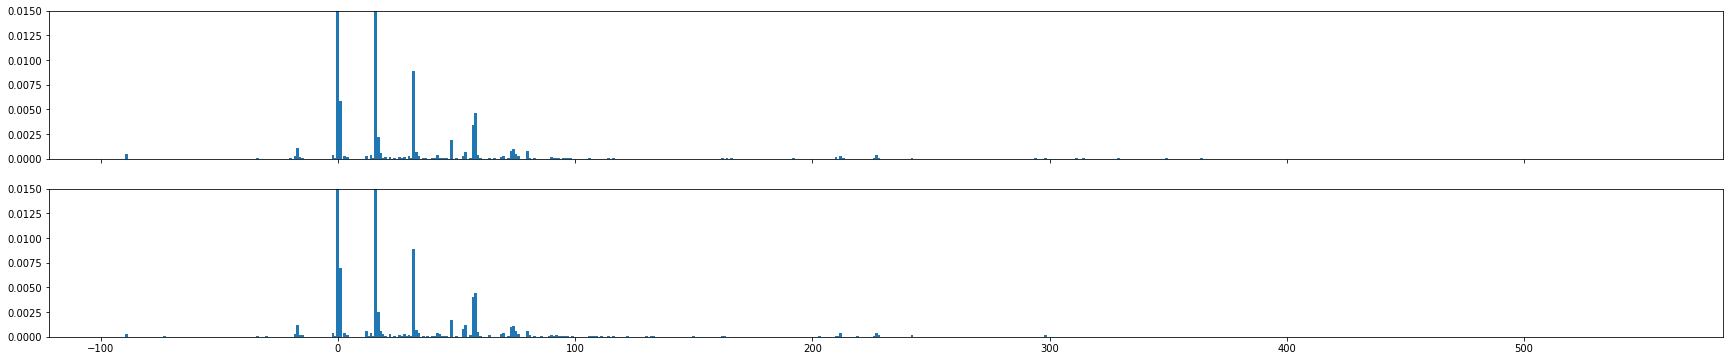

In [125]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
ax1.bar(x=data.delta_mass, height=data.PSM_count_H2O2, width=1.2)
ax2.bar(x=data.delta_mass, height=data.PSM_count_Control, width=1.2)
# sns.barplot(ax = axes[0], data=data, x="delta_mass", y="PSM_count_H2O2")
# sns.barplot(ax = axes[1], data=data, x="delta_mass", y="PSM_count_Control")

fig.set_size_inches(30,6)
plt.ylim(0,0.015)

plt.show()

In [329]:
# datafiltered = data.loc[(data["PSM_count_Control"]!= 0) & (data["PSM_count_H2O2"] != 0)]

In [330]:
# datafiltered

,delta_mass,PSM_count_Control,PSM_count_H2O2,Difference
0,-89.0299,0.000291,0.000474,0.387225
2,-58.0055,0.000020,0.000037,0.470786
3,-46.0055,0.000013,0.000037,0.647190
4,-37.0204,0.000013,0.000025,0.470786
5,-33.9877,0.000119,0.000100,-0.160181
...,...,...,...,...
523,372.1831,0.000013,0.000025,0.470786
525,383.1628,0.000013,0.000025,0.470786
527,387.1278,0.000020,0.000025,0.206178
535,447.1957,0.000013,0.000025,0.470786


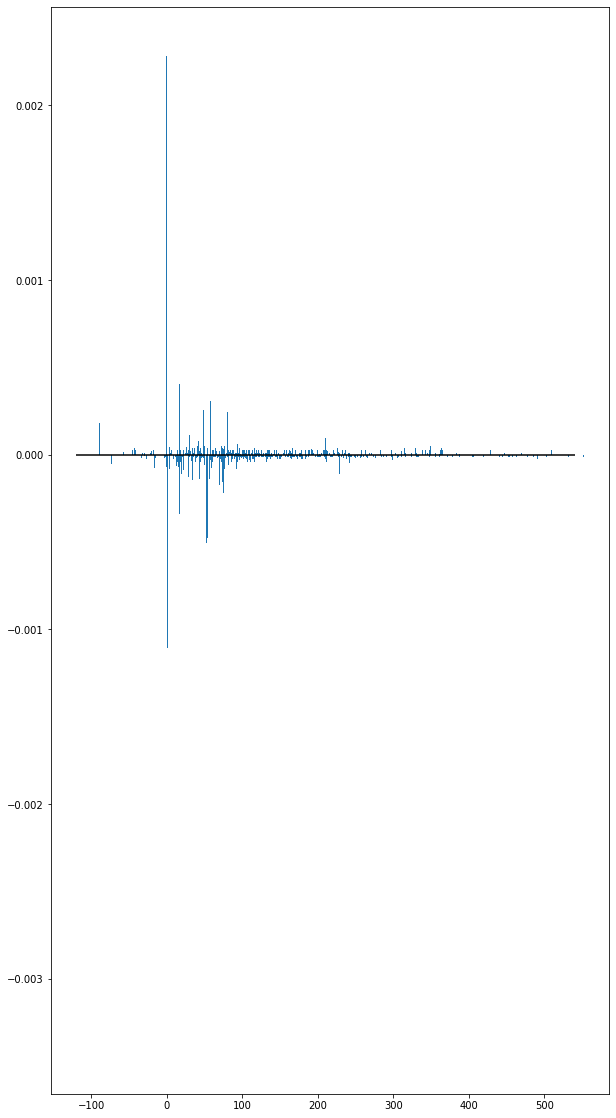

In [126]:
fig, ax = plt.subplots()
# sns.barplot(ax = ax, data=data, x="delta_mass", y="Difference")

ax.bar(x=data.delta_mass, height=data.Difference, width=1.2)
fig.set_size_inches(10,20)



# ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
plt.hlines(y=0, xmin=-120, xmax=540, colors="k")
# plt.ylim(-0.5e-6,0.5e-6)
plt.show()

In [127]:
sorted = data.sort_values(by="Difference", axis=0, ascending=False)

In [128]:
sorted.head(10)

,delta_mass,PSM_count_Control,PSM_count_H2O2,Difference
30,0.0000,0.214089,0.216371,0.002282
53,17.0265,0.001268,0.001672,0.000404
152,58.0055,0.004385,0.004692,0.000307
132,47.9847,0.001664,0.001922,0.000258
214,79.9663,0.000581,0.000824,0.000242
0,-89.0299,0.000291,0.000474,0.000184
79,30.0106,0.000211,0.000324,0.000113
426,210.0020,0.000053,0.000150,0.000097
153,58.0055,0.000792,0.000873,0.000081
60,19.9898,0.000119,0.000200,0.000081


0.0000: No mass shift

17.0265: ammonium gain

58.0055	: Carboxymethyl!

47.9847: cysteine oxidation to cysteic acid	!

79.9663: Phosphorylation

-89.0299: Removal of initiator methionine from protein N-terminus, then acetylation of the new N-terminus	

30.0106	: Hydroxymethyl


In [129]:
sorted.tail(10)

,delta_mass,PSM_count_Control,PSM_count_H2O2,Difference
177,68.9064,0.000330,0.000175,-0.000155
178,69.9142,0.000423,0.000250,-0.000173
38,12.0000,0.000541,0.000324,-0.000217
201,75.0321,0.000396,0.000175,-0.000222
52,16.9789,0.002509,0.002171,-0.000338
142,53.9193,0.001175,0.000699,-0.000477
140,52.9115,0.000832,0.000324,-0.000508
151,57.0215,0.004015,0.003394,-0.000621
31,0.9840,0.006947,0.005840,-0.001107
50,15.9949,0.046450,0.043075,-0.003375


15.9949: Oxidation

Deamidation: 0.984016

57.0215: Carbamidomethyl

52.9115	: Replacement of 3 protons by iron	

53.9193	: Replacement of 2 protons by iron

16.9789: Oxidation + Deamidation


# PXD012477

## Intensity based

### Pre-calculations

In [36]:
PXD012477 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD012477/flashlfq_results/QuantifiedPeptides.tsv", sep="\t")
PXD012477.drop(list(PXD012477.filter(regex = 'Detection Type')), axis = 1, inplace = True)
PXD012477.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_1DLC0080815QE_RRAG_001_rep1,Intensity_1DLC0080815QE_RRAG_001_rep2,Intensity_1DLC120314QE_RRAG_001_rep1,Intensity_1DLC120314QE_RRAG_001_rep2,Intensity_1DLC012615QE_RRAG_001B_rep1,...,Intensity_1DLC012615QE_RRAG_008B_rep4,Intensity_1DLC120914QE_RRAG_009_rep1,Intensity_1DLC120914QE_RRAG_009_rep2,Intensity_1DLC120914QE_RRAG_009_rep3,Intensity_1DLC120914QE_RRAG_009_rep4,Intensity_1DLC012615QE_RRAG_009B_rep1,Intensity_1DLC012615QE_RRAG_009B_rep2,Intensity_1DLC012615QE_RRAG_009B_rep3,Intensity_1DLC012615QE_RRAG_009B_rep4,Unnamed: 983
0,AAAAAAAAAAAAAAAASAGGKx|[1927]Delta:H(4)C(5)O(1...,AAAAAAAAAAAAAAAASAGGK,NaN,NaN,NaN,0.0,0.0,138225.983265,132484.074364,164815.085379,...,84877.380967,11178.165559,50411.293713,0.000000,0.000000,11447.805538,0.0,8570.250729,0.000000,NaN
1,AAAAAAAAAKNGSSGKnan,AAAAAAAAAKNGSSGK,NaN,NaN,NaN,0.0,0.0,59682.551616,33086.921842,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN
2,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.0,0.0,185776.556271,21026.774331,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN
3,AAAAAAAAGAFAGRR7|[1918]Carbonyl[A],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN
4,AAAAAAAAQMHAKx|[205]Delta:H(6)C(6)O(1)[K],AAAAAAAAQMHAK,NaN,NaN,NaN,0.0,0.0,27244.860745,22892.768392,317624.729897,...,202659.820247,26194.228624,0.000000,121790.360066,26474.929387,61698.145139,0.0,0.000000,17235.695643,NaN


In [37]:
cols =[]
for i in PXD012477.columns[5:-1]:
    cols.append(i)

In [38]:
OA.quantile_transform(PXD012477, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_1DLC0080815QE_RRAG_001_rep1,Intensity_1DLC0080815QE_RRAG_001_rep2,Intensity_1DLC120314QE_RRAG_001_rep1,Intensity_1DLC120314QE_RRAG_001_rep2,Intensity_1DLC012615QE_RRAG_001B_rep1,...,Intensity_1DLC012615QE_RRAG_008B_rep4,Intensity_1DLC120914QE_RRAG_009_rep1,Intensity_1DLC120914QE_RRAG_009_rep2,Intensity_1DLC120914QE_RRAG_009_rep3,Intensity_1DLC120914QE_RRAG_009_rep4,Intensity_1DLC012615QE_RRAG_009B_rep1,Intensity_1DLC012615QE_RRAG_009B_rep2,Intensity_1DLC012615QE_RRAG_009B_rep3,Intensity_1DLC012615QE_RRAG_009B_rep4,Unnamed: 983
0,AAAAAAAAAAAAAAAASAGGKx|[1927]Delta:H(4)C(5)O(1...,AAAAAAAAAAAAAAAASAGGK,NaN,NaN,NaN,NaN,NaN,5.858407,5.897686,5.883941,...,5.510266,3.977395,5.023162,NaN,NaN,4.203044,NaN,4.028068,NaN,NaN
1,AAAAAAAAAKNGSSGKnan,AAAAAAAAAKNGSSGK,NaN,NaN,NaN,NaN,NaN,5.182500,4.744882,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,6.071816,4.376360,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAGAFAGRR7|[1918]Carbonyl[A],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAAAAAQMHAKx|[205]Delta:H(6)C(6)O(1)[K],AAAAAAAAQMHAK,NaN,NaN,NaN,NaN,NaN,4.572496,4.443170,6.335264,...,6.063617,4.535847,NaN,5.411331,4.516309,5.119418,NaN,NaN,4.506613,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102383,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[100...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102384,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[131...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102385,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[6]C...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102386,YYYVCQYCPAGNWANR8|[4]carbamidomethyl[C]|5|[999...,YYYVCQYCPAGNWANR,CRIS3_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
PXD012477["Modifications"] = PXD012477["Sequence"].apply(modifications)
PXD012477["Delta_mass"] = PXD012477["Sequence"].apply(get_delta_mass)

In [40]:
No_zero = PXD012477[PXD012477["Delta_mass"] != 0]

In [41]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [42]:
g

,Delta_mass,Gene Names,Organism,Intensity_1DLC0080815QE_RRAG_001_rep1,Intensity_1DLC0080815QE_RRAG_001_rep2,Intensity_1DLC120314QE_RRAG_001_rep1,Intensity_1DLC120314QE_RRAG_001_rep2,Intensity_1DLC012615QE_RRAG_001B_rep1,Intensity_1DLC012615QE_RRAG_001B_rep2,Intensity_1DLC012615QE_RRAG_001B_rep3,...,Intensity_1DLC012615QE_RRAG_008B_rep4,Intensity_1DLC120914QE_RRAG_009_rep1,Intensity_1DLC120914QE_RRAG_009_rep2,Intensity_1DLC120914QE_RRAG_009_rep3,Intensity_1DLC120914QE_RRAG_009_rep4,Intensity_1DLC012615QE_RRAG_009B_rep1,Intensity_1DLC012615QE_RRAG_009B_rep2,Intensity_1DLC012615QE_RRAG_009B_rep3,Intensity_1DLC012615QE_RRAG_009B_rep4,Unnamed: 983
0,-94.041865,0.0,0.0,5.288978,9.549858,16.531377,10.774835,27.380648,26.654922,5.417397,...,16.575982,24.990239,20.157675,18.154860,17.782556,18.752673,22.195756,12.871445,20.759450,0.0
1,-89.029920,0.0,0.0,81.434986,99.068373,124.537088,143.645287,124.674463,140.736329,54.850434,...,122.778599,110.620429,129.527154,118.717986,120.027516,89.878552,102.634074,106.534876,95.579879,0.0
2,-78.046950,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.225564,0.000000,0.000000,0.000000,0.000000,0.000000,4.563862,0.0
3,-73.035005,0.0,0.0,5.917819,0.000000,0.000000,4.612289,0.000000,0.000000,5.238051,...,5.552057,6.019940,5.473394,5.650605,5.584276,9.076900,5.281757,4.822885,0.000000,0.0
4,-58.005479,0.0,0.0,26.798571,29.789605,57.667273,52.750318,59.150582,51.672302,20.033680,...,75.274449,57.730431,67.786022,59.155301,46.396663,70.686263,51.706552,63.485009,82.522488,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,557.244541,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1613,563.190597,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1614,587.262499,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1615,588.293443,0.0,0.0,0.000000,0.000000,0.000000,4.622689,6.231109,5.797805,0.000000,...,3.489459,0.000000,0.000000,0.000000,4.447450,0.000000,0.000000,5.036801,0.000000,0.0


In [43]:
dict = {}
patientIDlist = []
patientIDBlist = []
for i in range(1,66):
    patientID = "_"+str(i).zfill(3)+"_"
    patientIDB = "_"+str(i).zfill(3)+"B_"
    patientIDlist.append(patientID)
    patientIDBlist.append(patientIDB)
for patient in patientIDlist:
    selected = g[[col for col in g if patient in col]]
    selected["Delta_mass"] = g["Delta_mass"]
    dict[patient] = selected
for patientB in patientIDBlist:
    selectedB = g[[col for col in g if patientB in col]]
    selected["Delta_mass"] = g["Delta_mass"]
    dict[patientB] = selectedB

In [44]:
for i in dict:
    df = dict[i]
    df["median"] = df.median(axis=1)

In [45]:
data = pd.DataFrame()
data["Delta_mass"] = g["Delta_mass"]
for patient in dict:
    data[patient] = dict[patient]["median"]

In [46]:
data.dropna(axis=1, inplace=True)
data

,Delta_mass,_001_,_002_,_003_,_004_,_005_,_006_,_007_,_008_,_009_,...,_053B_,_054B_,_055B_,_056B_,_058B_,_059B_,_060B_,_061B_,_062B_,_064B_
0,-94.041865,9.549858,6.199684,4.916327,13.478940,13.768652,15.287587,17.333435,12.510942,18.154860,...,7.949539,0.000000,7.084016,4.884702,6.550274,0.000000,13.437220,5.080616,2.247756,15.052359
1,-89.029920,99.068373,63.693538,100.622481,99.048083,110.009395,122.229189,95.431060,109.243962,118.717986,...,104.269997,61.413587,81.010613,133.784592,117.752800,50.994648,110.170965,128.953137,102.109253,134.600027
2,-78.046950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-73.035005,0.000000,0.000000,0.000000,5.165159,0.000000,0.000000,0.000000,5.128251,5.584276,...,4.544528,5.263862,5.214332,5.294136,0.000000,4.996144,4.904302,4.696375,4.518662,0.000000
4,-58.005479,29.789605,30.633576,50.555017,30.908377,58.879198,60.379289,64.528958,66.189972,57.730431,...,59.416652,49.086682,57.535841,60.963548,50.558479,47.190421,59.285765,57.929708,51.629417,57.670511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612,557.244541,0.000000,0.000000,0.000000,0.000000,3.296599,3.393711,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1613,563.190597,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1614,587.262499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1615,588.293443,0.000000,0.000000,0.000000,0.000000,4.875569,4.286715,3.830873,4.076379,0.000000,...,0.000000,2.657254,2.687719,5.555856,5.836680,2.903652,2.647237,4.599346,0.000000,4.493865


In [47]:
Healthydf = pd.DataFrame()
NonHealthydf = pd.DataFrame()
Healthydf["Delta_mass"] = data["Delta_mass"]
NonHealthydf["Delta_mass"] = data["Delta_mass"]
Healthy = [1,3,4,5,6,11,13,14,19,21,23,24,25,28,29,32,33,34,36,37,40,41,42,47,52,54,56,57,60,61,65]
NonHealthy = [2,7,9,10,12,15,17,18,20,22,26,27,30,31,35,38,39,43,44,45,46,48,49,50,51,53,55,58,59,62,63,64,8,16]
patienlist = []
patienBlist = []
for i in Healthy:
    patien = "_"+str(i).zfill(3)+"_"
    patienlist.append(patien)
    patienB = "_"+str(i).zfill(3)+"B_"
    patienBlist.append(patienB)

for i in patienlist:
    if i in data.columns:
        Healthydf[i] = data[i]
for i in patienBlist:
    if i in data.columns:
        Healthydf[i] = data[i]


patielist = []
patieBlist = []
data["Delta_mass"] = g["Delta_mass"]
for i in NonHealthy:
    patie = "_"+str(i).zfill(3)+"_"
    patielist.append(patie)
    patieB = "_"+str(i).zfill(3)+"B_"
    patieBlist.append(patieB)

for i in patielist:
    if i in data.columns:
        NonHealthydf[i] = data[i]
for i in patieBlist:
    if i in data.columns:
        NonHealthydf[i] = data[i]

In [48]:
Healthydf.set_index("Delta_mass",inplace=True)
Healthy = Healthydf.median(axis=1).to_frame().reset_index()

NonHealthydf.set_index("Delta_mass", inplace=True)
NonHealthy = NonHealthydf.median(axis=1).to_frame().reset_index()


In [50]:
data = pd.merge(Healthy, NonHealthy, how="outer", on=["Delta_mass", "Delta_mass"], suffixes=["H","NH"])

In [51]:
data

,Delta_mass,0H,0NH
0,-94.041865,11.892461,12.410639
1,-89.029920,110.125174,105.328042
2,-78.046950,0.000000,0.000000
3,-73.035005,3.380142,4.688720
4,-58.005479,58.404453,54.428428
...,...,...,...
1612,557.244541,0.000000,0.000000
1613,563.190597,0.000000,0.000000
1614,587.262499,0.000000,0.000000
1615,588.293443,2.816070,2.370502


In [52]:
# data["Quotient"] = ((data["0NH"] - data["0H"])/ data["0H"]).where( data["0H"] >= data["0NH"], other=(data["0NH"] - data["0H"])/ data["0NH"])
data["Difference"] = data["0NH"] - data["0H"]
# data.fillna(0, inplace=True)
# g["Quotient"] = ((g["meanNH"] - g["meanH"])/ g["meanNH"]).where( g["meanH"] < g["meanNH"])


### Plots

In [53]:
data

,Delta_mass,0H,0NH,Difference
0,-94.041865,11.892461,12.410639,0.518177
1,-89.029920,110.125174,105.328042,-4.797131
2,-78.046950,0.000000,0.000000,0.000000
3,-73.035005,3.380142,4.688720,1.308578
4,-58.005479,58.404453,54.428428,-3.976025
...,...,...,...,...
1612,557.244541,0.000000,0.000000,0.000000
1613,563.190597,0.000000,0.000000,0.000000
1614,587.262499,0.000000,0.000000,0.000000
1615,588.293443,2.816070,2.370502,-0.445568


In [398]:
# datafiltered = data[(data["0H"] !=0) & (data["0NH"] !=0) ]


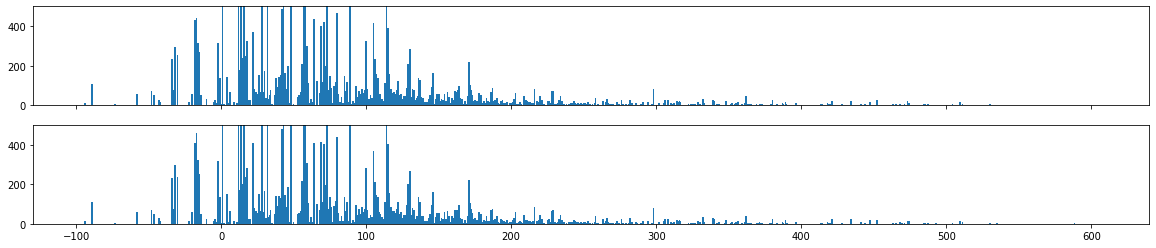

In [54]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=data.Delta_mass, height=data["0NH"], width=1.2)
ax2.bar(x=data.Delta_mass, height=data["0H"], width=1.2)

fig.set_size_inches(20,4)
plt.ylim(0,500)
plt.show()

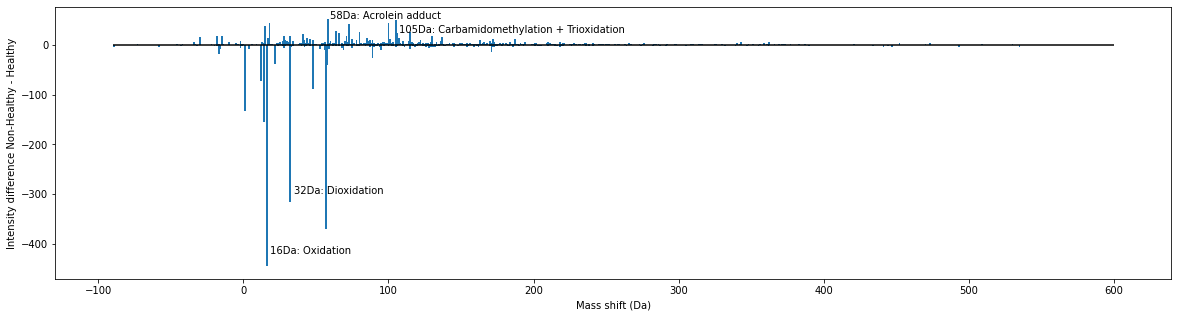

In [59]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=data.Delta_mass, height=data.Difference, width=1.2)
fig.set_size_inches(20,5)
plt.hlines(y=0,xmin=-90, xmax=600, color="k")
plt.ylabel("Intensity difference Non-Healthy - Healthy")
plt.xlabel("Mass shift (Da)")
plt.text(x=60,y=52,s="58Da: Acrolein adduct")
plt.text(x=18, y = -420, s="16Da: Oxidation")
plt.text(x = 107, y=25, s= "105Da: Carbamidomethylation + Trioxidation")
plt.text(x=35, y = -300, s="32Da: Dioxidation")

# plt.ylim(0,7000)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

In [157]:
sorted = data.sort_values(by="Difference", axis=0, ascending=False)

In [158]:
sorted.head(10)

,Delta_mass,0H,0NH,Quotient,Difference
216,58.041865,371.117558,422.077088,0.120735,50.959530
434,105.006208,368.964887,417.958548,0.117221,48.993661
405,100.027278,280.855827,325.472066,0.137082,44.616239
84,17.990578,282.728577,325.625579,0.131737,42.897002
278,73.016379,1670.758709,1711.110929,0.023582,40.352220
74,14.999666,199.812306,238.222751,0.161238,38.410445
76,15.010899,188.176656,225.389641,0.165105,37.212985
404,100.016044,161.370503,191.643486,0.157965,30.272983
241,63.979659,406.848759,434.812374,0.064312,27.963615
484,115.063329,187.708419,213.681957,0.121552,25.973538


58.041865: Reduced acrolein addition +58	

105.006208: Carbamidomethylation + Trioxidation

100.027278: Carbamidomethylation + Carbamyl

17.990578: fluorination

73.016379: Carbamidomethylation + Oxidation

14.999666: Deamidation followed by a methylation

15.010899: Aminotyrosine (staatt in lijst van Hawkins?)

100.016044: Methylmalonylation

63.979659: Tryptophan oxidation to dihydroxy-N-formaylkynurenine	

115.063329: Reduced acrolein addition +58	+ Carbamidomethylation

In [165]:
sorted.tail(10)

,Delta_mass,0H,0NH,Quotient,Difference
92,21.981943,409.296216,371.269612,-0.092907,-38.026604
213,58.005480,1239.339952,1199.561981,-0.032096,-39.777971
124,31.989830,675.327103,610.716097,-0.095674,-64.611006
62,12.000000,1882.863029,1809.174178,-0.039137,-73.688851
179,47.984744,2015.211345,1926.954906,-0.043795,-88.256440
51,0.984016,3778.496273,3647.395471,-0.034697,-131.100802
69,13.979265,1979.976857,1825.202890,-0.078170,-154.773967
123,31.989829,3464.145839,3147.443875,-0.091423,-316.701964
211,57.021464,11910.308629,11541.679925,-0.030950,-368.628703
80,15.994915,7581.167972,7138.311509,-0.058415,-442.856463


15.994915: Oxidation

57.021464: Carbamidomethylation

31.989829: Dioxidation

13.97926: Carbonylation 

0.984016: Deamidation

47.984744: Trioxidation

12: formaldehyde adduct	

31.989830: Two oxidations

58.005480: Carboxymethyl

21.981943: Sodium adduct		


## PSM count

In [166]:
PXD012477_first = pd.read_csv("/home/robbe/ionbot/full_projects_/PXD012477/PXD012477_first.csv")

In [167]:
PXD012477_first["delta_mass"] = PXD012477_first["modifications_delta"].apply(get_delta_mass_first)

In [168]:
g1 = PXD012477_first.groupby(["delta_mass", "spectrum_file"])["ionbot_match_id"].count().reset_index()

In [169]:
g1["Subject"] = g1["spectrum_file"].apply(lambda x: x.split("_")[2][:3])

In [170]:
g2 = g1.groupby(["delta_mass","Subject"]).median().reset_index()

In [171]:
metadict = {"001" : "Healthy", 
"003" : "Healthy",
"004" : "Healthy",
"005" : "Healthy",
"006" : "Healthy",
"008": "Non-Healthy",
"011" : "Healthy",
"013" : "Healthy", 
"014" : "Healthy",
"016" : "Non-Healthy",
"019" : "Healthy",
"021" : "Healthy",
"023" : "Healthy",
"024" : "Healthy",
"025" : "Healthy",
"028" : "Healthy",
"029" : "Healthy",
"032" : "Healthy",
"033" : "Healthy",
"034" : "Healthy",
"036" : "Healthy",
"037" : "Healthy",
"040" : "Healthy",
"041" : "Healthy",
"042" : "Healthy",
"047" : "Healthy",
"052" : "Healthy",
"054" : "Healthy",
"056" : "Healthy",
"057" : "Healthy",
"060" : "Healthy",
"061" : "Healthy",
"065" : "Healthy",
"002" : "Non-Healthy",
"007" : "Non-Healthy",
"009" : "Non-Healthy",
"010" : "Non-Healthy",
"012" : "Non-Healthy",
"015" : "Non-Healthy",
"017" : "Non-Healthy",
"018" : "Non-Healthy",
"020" : "Non-Healthy",
"022" : "Non-Healthy",
"026" : "Non-Healthy",
"027" : "Non-Healthy",
"030" : "Non-Healthy",
"031" : "Non-Healthy",
"035" : "Non-Healthy",
"038" : "Non-Healthy",
"039" : "Non-Healthy",
"043" : "Non-Healthy",
"044" : "Non-Healthy",
"045" : "Non-Healthy",
"046" : "Non-Healthy",
"048" : "Non-Healthy",
"049" : "Non-Healthy",
"050" : "Non-Healthy",
"051" : "Non-Healthy",
"053" : "Non-Healthy",
"055" : "Non-Healthy",
"058" : "Non-Healthy",
"059" : "Non-Healthy",
"062" : "Non-Healthy",
"063" : "Non-Healthy",
"064" : "Non-Healthy",
}

In [172]:
g2["Status"] = g2["Subject"].apply(lambda x: metadict[x])

In [173]:
g3 = g2.groupby(["delta_mass", "Status"]).median().reset_index()

In [174]:
Hmedian = g3.loc[g3["Status"] == "Healthy"]
NHmedian = g3.loc[g3["Status"] == "Non-Healthy"]

In [175]:
Hmedian.rename(columns={"ionbot_match_id": "PSM_count"}, inplace=True)
NHmedian.rename(columns={"ionbot_match_id":"PSM_count"}, inplace=True)


In [176]:
data = pd.merge(Hmedian, NHmedian, on=["delta_mass", "delta_mass"], suffixes=["_H","_NH"])

In [178]:
data["PSM_count_H"] = data["PSM_count_H"] / 2736885
data["PSM_count_NH"] = data["PSM_count_NH"] / 3058615
# data["Difference"] = ((data["PSM_count_NH"] - data["PSM_count_H"]) / data["PSM_count_H"]).where(data["PSM_count_H"]>= data["PSM_count_NH"], other=(data["PSM_count_NH"]-data["PSM_count_H"])/ data["PSM_count_NH"])
data["Difference"] = data["PSM_count_NH"] - data["PSM_count_H"]

In [184]:
datanotzero = data.drop(46)

In [27]:
# data.replace(np.nan, 0, inplace=True)

In [28]:
# data["Difference"] = data["PSM_count_NH"] - data["PSM_count_H"]

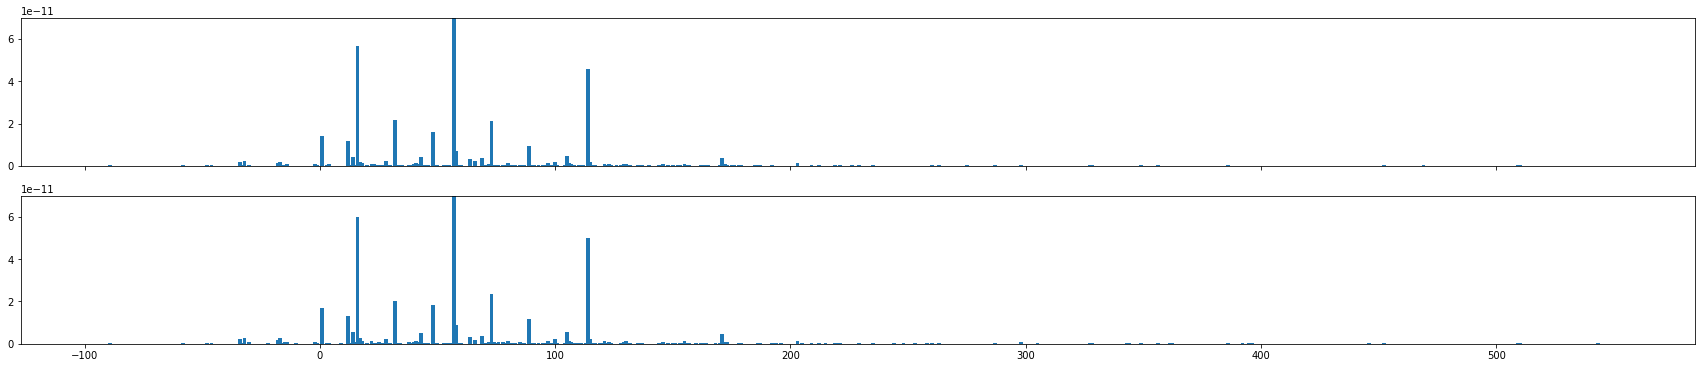

In [185]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
ax1.bar(x=datanotzero.delta_mass, height=datanotzero.PSM_count_NH, width=1.6)
ax2.bar(x=datanotzero.delta_mass, height=datanotzero.PSM_count_H, width=1.6)
# sns.barplot(ax = axes[0], datanotzero=data, x="delta_mass", y="PSM_count_H2O2")
# sns.barplot(ax = axes[1], data=data, x="delta_mass", y="PSM_count_Control")

fig.set_size_inches(30,6)
plt.ylim(0,0.7e-10)

plt.show()

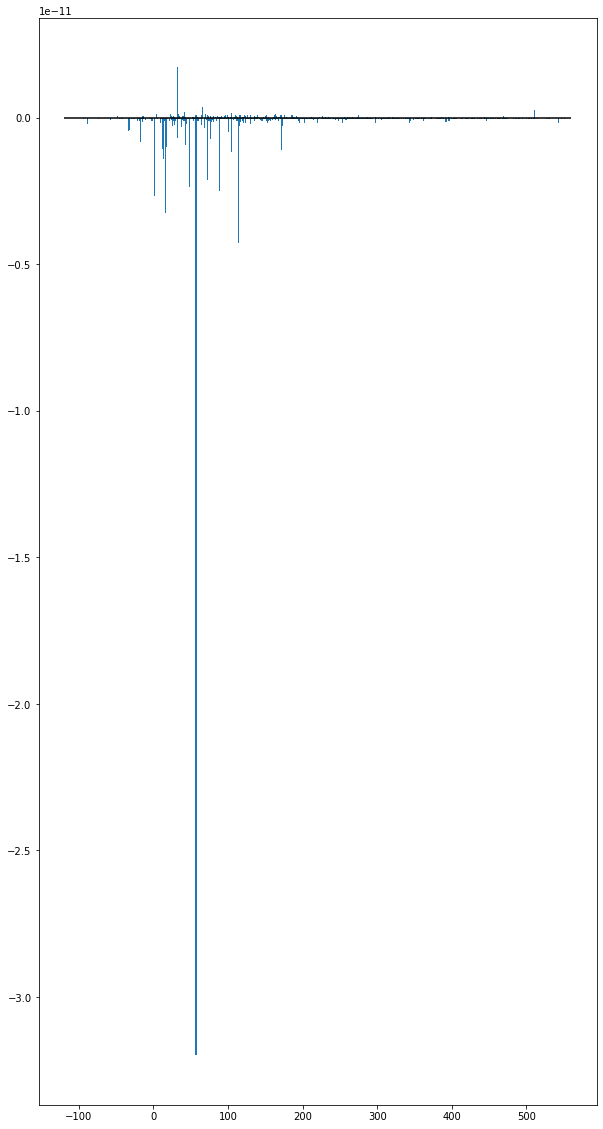

In [187]:
fig, ax = plt.subplots()
# sns.barplot(ax = ax, data=data, x="delta_mass", y="Difference")

ax.bar(x=datanotzero.delta_mass, height=datanotzero.Difference, width=1.4)
fig.set_size_inches(10,20)



# ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
plt.hlines(y=0, xmin=-120, xmax=560, colors="k")
# plt.ylim(-0.000025,0.000025)
plt.show()

In [189]:
sorted = datanotzero.sort_values(by="Difference", axis=0, ascending=False)

In [190]:
sorted.head(10)

,delta_mass,Status_H,PSM_count_H,Status_NH,PSM_count_NH,Difference
112,31.9898,Healthy,1.999188e-11,Non-Healthy,2.172606e-11,1.734173e-12
226,66.0106,Healthy,1.802273e-12,Non-Healthy,2.164589e-12,3.623154e-13
1146,510.1697,Healthy,1.668772e-13,Non-Healthy,4.275731e-13,2.606959e-13
142,41.0014,Healthy,1.268266e-12,Non-Healthy,1.469782e-12,2.015160e-13
369,105.0215,Healthy,9.011367e-13,Non-Healthy,1.068933e-12,1.677960e-13
49,3.9949,Healthy,5.340069e-13,Non-Healthy,6.680830e-13,1.340760e-13
239,70.0531,Healthy,1.335017e-13,Non-Healthy,2.672332e-13,1.337314e-13
85,23.0338,Healthy,5.673824e-13,Non-Healthy,6.948063e-13,1.274239e-13
613,164.0602,Healthy,3.003789e-13,Non-Healthy,4.275731e-13,1.271942e-13
116,33.0294,Healthy,2.002526e-13,Non-Healthy,3.206798e-13,1.204272e-13


31.9898: Dioxidation

66.0106: Furan

510.1697: HexNAc NeuGc	

41.0014: Azidophenylalanine

105.0215: Nicotinic acid

3.9949: tryptophan oxidation to kynurenin	

70.0531: Carbamidomethyl + Methylamine

23.0338: Carbamidomethyl + Cys->Dha

164.0602 : Diisopropylphosphate	

33.0294: Oxidation + deuterated methyl ester


In [199]:
sorted.tail(10)

,delta_mass,Status_H,PSM_count_H,Status_NH,PSM_count_NH,Difference
62,14.0157,Healthy,5.340069e-12,Non-Healthy,4.142114e-12,-1.197955e-12
61,13.9793,Healthy,4.906189e-12,Non-Healthy,3.500755e-12,-1.405434e-12
196,58.0055,Healthy,9.011367e-12,Non-Healthy,7.135126e-12,-1.876241e-12
253,73.0164,Healthy,2.346293e-11,Non-Healthy,2.135193e-11,-2.110998e-12
166,47.9847,Healthy,1.842324e-11,Non-Healthy,1.606071e-11,-2.362525e-12
312,89.0113,Healthy,1.171478e-11,Non-Healthy,9.219545e-12,-2.495232e-12
47,0.9840,Healthy,1.668772e-11,Non-Healthy,1.402974e-11,-2.657975e-12
69,15.9949,Healthy,5.964190e-11,Non-Healthy,5.638620e-11,-3.255698e-12
404,114.0430,Healthy,4.986290e-11,Non-Healthy,4.558998e-11,-4.272916e-12
194,57.0215,Healthy,2.099982e-10,Non-Healthy,1.780040e-10,-3.199420e-11


57.0215: Carbamidomethyl

114.0430: Ubiquitination

15.9949: Oxidation

0.9840: Amidation

89.0113: Carbamidomethyl + Dioxidation

47.9847: Trioxidation

73.0164: Oxidation + Carbamidomethyl

58.0055: Carboxymethyl

13.9793: Tryptophan oxidation to oxolactone	or proline oxidation to pyroglutamic acid	

14.0157: Methylation





## PXD016278

## Intensity based

### Calculations

In [60]:
PXD016278 = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD016278/flashlfq/QuantifiedPeptides.tsv", sep="\t")
PXD016278.drop(list(PXD016278.filter(regex = 'Detection Type')), axis = 1, inplace = True)
PXD016278.head()

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,AAAAAAAAAAAAAAAGAGAGAKnan,AAAAAAAAAAAAAAAGAGAGAK,S12A2_HUMAN,NaN,NaN,0.000000e+00,0.000000,0.000,0.0,0.0,...,2.016063e+05,6.783181e+05,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,NaN
1,AAAAAAAAAKnan,AAAAAAAAAK,PHX2B_HUMAN,NaN,NaN,0.000000e+00,0.000000,0.000,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,NaN
2,AAAAAAAAAVSRR12|[981]glucosone[R],AAAAAAAAAVSRR,NaN,NaN,NaN,3.159841e+06,263986.097656,0.000,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,NaN
3,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000e+00,0.000000,0.000,0.0,0.0,...,1.550330e+06,2.073836e+06,0.0,0.0,0.0,0.0,3.529714e+06,2.289962e+07,0.0,NaN
4,AAAAAAAAGAFAGRR15|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,0.000000e+00,0.000000,6137970.625,8516465.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,NaN


In [61]:
cols =[]
for i in PXD016278.columns[5:-1]:
    cols.append(i)

In [62]:
OA.quantile_transform(PXD016278, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,AAAAAAAAAAAAAAAGAGAGAKnan,AAAAAAAAAAAAAAAGAGAGAK,S12A2_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.374836,4.591134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAAAAAAKnan,AAAAAAAAAK,PHX2B_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAAAAAAAAVSRR12|[981]glucosone[R],AAAAAAAAAVSRR,NaN,NaN,NaN,5.644241,4.556679,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAGAFAGRR14|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.714461,5.304105,NaN,NaN,NaN,NaN,5.122593,6.092077,NaN,NaN
4,AAAAAAAAGAFAGRR15|[1918]Carbonyl[R],AAAAAAAAGAFAGRR,NaN,NaN,NaN,NaN,NaN,5.801429,5.927171,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108603,YYYAVYDMVVR8|[35]oxidation[M],YYYAVYDMVVR,LAMB1_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108604,YYYAVYDMVVRnan,YYYAVYDMVVR,LAMB1_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.489088,4.648204,NaN,NaN,NaN,NaN,NaN,NaN,4.69236,NaN
108605,YYYDGKDYIEFNK6|[4]Carbamidomethyl[K],YYYDGKDYIEFNK,ZA2G_HUMAN,NaN,NaN,5.075188,4.694472,NaN,NaN,5.021263,...,4.376519,4.546711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108606,YYYDGKDYIEFNKnan,YYYDGKDYIEFNK,ZA2G_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
PXD016278["Modifications"] = PXD016278["Sequence"].apply(modifications)
PXD016278["Delta_mass"] = PXD016278["Sequence"].apply(get_delta_mass)

In [64]:
No_zero = PXD016278[PXD016278["Delta_mass"] != 0]

In [65]:
g = No_zero.groupby("Delta_mass").sum().reset_index()

In [66]:
g

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction16,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction17,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101
0,-94.041865,0.0,0.0,0.000000,0.000000,0.000000,5.273945,3.907864,4.245048,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.284232,0.000000,0.000000,0.000000,0.000000,0.0
1,-89.029920,0.0,0.0,5.093267,10.888405,11.128523,9.054536,28.658164,32.892761,11.471245,...,13.353761,4.996367,4.646425,11.265526,19.449107,23.286075,9.942100,0.000000,9.479501,0.0
2,-73.035005,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.733968,4.056953,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,-58.005479,0.0,0.0,5.695234,4.437082,20.283829,10.376134,0.000000,0.000000,0.000000,...,0.000000,13.854979,19.549741,10.625485,4.601573,4.737187,9.710958,5.677064,15.185990,0.0
4,-48.003371,0.0,0.0,25.628343,20.180233,42.765801,24.005694,30.380902,51.960253,52.761162,...,46.604250,52.254966,68.279221,40.515084,30.450835,32.085989,48.361448,60.278858,58.541966,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,561.238607,0.0,0.0,0.000000,0.000000,0.000000,0.000000,4.210031,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1494,563.190597,0.0,0.0,0.000000,0.000000,5.049604,4.015923,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1495,568.253315,0.0,0.0,0.000000,0.000000,4.391701,3.637485,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1496,572.205319,0.0,0.0,0.000000,0.000000,15.190195,18.636926,12.170027,12.532800,16.035672,...,5.419732,0.000000,10.116559,19.395798,21.544468,10.515483,11.067974,4.125063,5.234600,0.0


In [67]:
from statistics import median
g['medianCtrl']=g.apply(lambda x:median([x[c] for c in g.columns if "ctrl2" in c]),axis=1)
g["medianAD"]=g.apply(lambda x:median([x[c] for c in g.columns if "AD2" in c]), axis=1)

In [68]:
g

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction18,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,medianCtrl,medianAD
0,-94.041865,0.0,0.0,0.000000,0.000000,0.000000,5.273945,3.907864,4.245048,0.000000,...,0.000000,0.000000,6.284232,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,-89.029920,0.0,0.0,5.093267,10.888405,11.128523,9.054536,28.658164,32.892761,11.471245,...,4.646425,11.265526,19.449107,23.286075,9.942100,0.000000,9.479501,0.0,9.954498,10.281688
2,-73.035005,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.733968,4.056953,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,-58.005479,0.0,0.0,5.695234,4.437082,20.283829,10.376134,0.000000,0.000000,0.000000,...,19.549741,10.625485,4.601573,4.737187,9.710958,5.677064,15.185990,0.0,5.998734,5.274432
4,-48.003371,0.0,0.0,25.628343,20.180233,42.765801,24.005694,30.380902,51.960253,52.761162,...,68.279221,40.515084,30.450835,32.085989,48.361448,60.278858,58.541966,0.0,44.167511,41.815026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,561.238607,0.0,0.0,0.000000,0.000000,0.000000,0.000000,4.210031,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1494,563.190597,0.0,0.0,0.000000,0.000000,5.049604,4.015923,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1495,568.253315,0.0,0.0,0.000000,0.000000,4.391701,3.637485,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1496,572.205319,0.0,0.0,0.000000,0.000000,15.190195,18.636926,12.170027,12.532800,16.035672,...,10.116559,19.395798,21.544468,10.515483,11.067974,4.125063,5.234600,0.0,5.327166,10.723634


In [86]:
# g["Quotient"] = ((g["medianAD"] - g["medianCtrl"])/ g["medianCtrl"]).where( g["medianCtrl"] >= g["medianAD"], other=(g["medianAD"] - g["medianCtrl"])/ g["medianAD"])

In [69]:
g["Difference"] = g["medianAD"] - g["medianCtrl"]

In [91]:
# g["Quotient"].replace(np.nan, 0, inplace=True)

In [95]:
# gfiltered = g[(g["medianCtrl"] !=0) & (g["medianH2O2"] !=0) ]


### Plots

In [70]:
g

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,medianCtrl,medianAD,Difference
0,-94.041865,0.0,0.0,0.000000,0.000000,0.000000,5.273945,3.907864,4.245048,0.000000,...,0.000000,6.284232,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,-89.029920,0.0,0.0,5.093267,10.888405,11.128523,9.054536,28.658164,32.892761,11.471245,...,11.265526,19.449107,23.286075,9.942100,0.000000,9.479501,0.0,9.954498,10.281688,0.327189
2,-73.035005,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.733968,4.056953,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,-58.005479,0.0,0.0,5.695234,4.437082,20.283829,10.376134,0.000000,0.000000,0.000000,...,10.625485,4.601573,4.737187,9.710958,5.677064,15.185990,0.0,5.998734,5.274432,-0.724302
4,-48.003371,0.0,0.0,25.628343,20.180233,42.765801,24.005694,30.380902,51.960253,52.761162,...,40.515084,30.450835,32.085989,48.361448,60.278858,58.541966,0.0,44.167511,41.815026,-2.352486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,561.238607,0.0,0.0,0.000000,0.000000,0.000000,0.000000,4.210031,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1494,563.190597,0.0,0.0,0.000000,0.000000,5.049604,4.015923,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1495,568.253315,0.0,0.0,0.000000,0.000000,4.391701,3.637485,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1496,572.205319,0.0,0.0,0.000000,0.000000,15.190195,18.636926,12.170027,12.532800,16.035672,...,19.395798,21.544468,10.515483,11.067974,4.125063,5.234600,0.0,5.327166,10.723634,5.396468


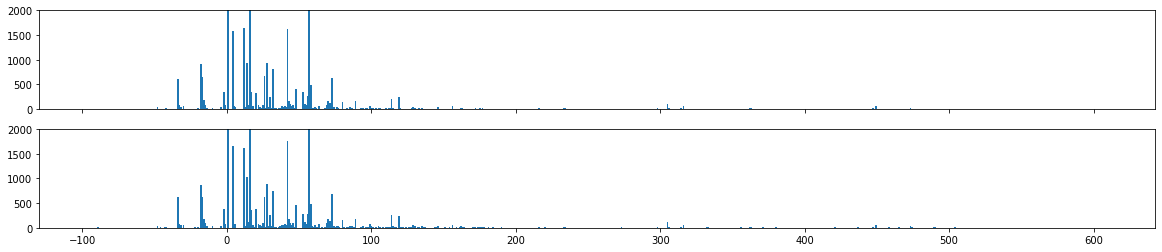

In [71]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
# sns.barplot(ax = axes[0], data=gfiltered, x="Delta_mass", y="meanH2O2")
# sns.barplot(ax = axes[1], data=gfiltered, x="Delta_mass", y="meanCtrl")
ax1.bar(x=g.Delta_mass, height=g.medianAD, width=1.2)
ax2.bar(x=g.Delta_mass, height=g.medianCtrl, width=1.2)

fig.set_size_inches(20,4)
plt.ylim(0,2000)
plt.show()

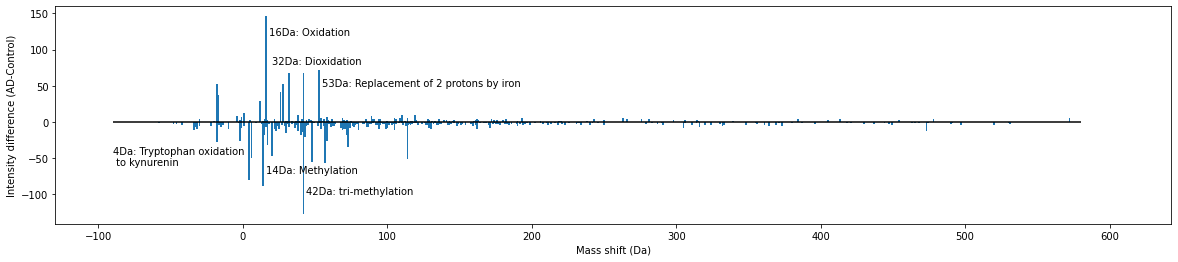

In [87]:
fig, ax = plt.subplots()
# ax = sns.barplot(data=gfiltered, x="Delta_mass", y="Quotient")
ax.bar(x=g.Delta_mass, height=g.Difference, width=1.2)
fig.set_size_inches(20,4)
plt.hlines(y=0,xmin=-90, xmax=580, color="k")
plt.xlabel("Mass shift (Da)")
plt.ylabel("Intensity difference (AD-Control)")
plt.text(x=18, y= 120, s= "16Da: Oxidation")
plt.text(x=20, y= 80, s="32Da: Dioxidation")
plt.text(x=55, y=50, s= "53Da: Replacement of 2 protons by iron")
plt.text(x=44, y = -100, s="42Da: Tri-methylation")
plt.text(x=16, y = -70, s="14Da: Methylation")
plt.text(x=-90, y=-60, s="4Da: Tryptophan oxidation \n to kynurenin")
# plt.ylim(0,7000)
# plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

In [215]:
sorted = g.sort_values(by="Difference", axis=0, ascending=False)

In [216]:
sorted.head(10)

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,medianCtrl,medianAD,Difference
80,15.994915,0.0,0.0,3219.615599,3634.081097,5450.713125,5767.650192,6093.958197,6828.062404,5515.164456,...,5242.857507,5006.842456,5127.766353,4986.362612,5154.844079,5321.446399,0.0,5207.740667,5352.236628,144.495960
195,52.911464,0.0,0.0,129.178977,181.534363,385.588391,326.180889,271.817626,237.683933,178.309636,...,209.896402,328.025802,336.724257,198.107811,168.513219,262.901777,0.0,281.977485,354.111519,72.134035
158,42.010565,0.0,0.0,277.775968,383.366878,538.778784,382.802519,378.361192,423.543431,328.503361,...,487.222867,515.245005,512.470111,553.466917,563.413893,589.229718,0.0,511.414924,579.403864,67.988940
125,31.989829,0.0,0.0,546.577021,652.374395,817.040208,873.500019,933.914059,941.600796,1004.112373,...,713.108582,647.661405,731.188348,690.480264,712.289920,774.803730,0.0,747.023702,814.709452,67.685750
23,-18.010565,0.0,0.0,569.330456,660.396707,934.386543,859.579000,922.656232,845.613520,864.272647,...,842.551330,839.691715,982.704576,941.234116,849.515342,876.018154,0.0,865.428403,918.735700,53.307297
106,27.994915,0.0,0.0,1245.629350,692.514181,829.694942,902.677228,848.193487,879.440372,937.365832,...,950.915907,821.289744,786.211371,651.267886,997.519030,1160.925072,0.0,888.715709,941.295285,52.579576
100,26.015650,0.0,0.0,234.587283,316.782503,479.732348,474.194932,413.144362,473.877421,445.631770,...,728.193898,810.391187,623.258370,586.075998,638.327102,671.390402,0.0,631.002971,671.905902,40.902931
25,-17.026549,0.0,0.0,348.067574,345.804935,631.438051,692.118855,676.509879,706.178461,598.686311,...,666.361096,638.424174,769.312063,760.461992,641.642817,659.321751,0.0,622.782512,659.944158,37.161646
60,12.000000,0.0,0.0,718.037662,1041.518623,1547.926971,1427.192697,1263.374189,1374.122546,1232.890659,...,1650.762341,1607.722893,1572.849638,1585.802165,1620.117022,1700.772733,0.0,1613.919958,1643.212036,29.292079
108,28.031300,0.0,0.0,232.681303,303.279309,391.931913,315.358017,343.753883,367.332457,383.021879,...,587.181643,483.063059,454.188064,456.749793,438.094479,561.036067,0.0,459.491127,483.134535,23.643408


15.994915: Oxidation (yes)

52.911464: Replacement of 3 protons by iron	 (iron accumulation is definitely associated but AD but maybe a stretch)

42.010565: Acetylation (can't really find anything)

31.989829: Dioxidation (yes)

-18.010565: Dehydration (a range of diff. things depending on what AA)

27.994915: Formylation (can't find anything, Unimod says this is artefact)

26.015650: Acetaldehyde adduct (Aldehyde metabolism is impaired in AD but maybe a stretch)

-17.026549	: Loss of ammonia	(can't really find anything)

12: formaldehyde adduct	(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6878761/)

28.031300: Acetaldehyde +28	adduct (Again!)

In [217]:
sorted.tail(10)

,Delta_mass,Gene Names,Organism,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction01,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction02R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction03_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction04_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction05_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction06_R2,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_AD2_fraction07_R2,...,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction19,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction20,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction21,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction22,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction23,Intensity_20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM1R2_library_ctrl2_fraction24,Unnamed: 101,medianCtrl,medianAD,Difference
83,17.026549,0.0,0.0,60.578825,99.252528,151.357544,114.902529,61.876133,72.584305,60.203373,...,76.870641,86.946714,80.525458,82.217574,60.111456,84.573598,0.0,109.031170,76.544654,-32.486516
283,73.016379,0.0,0.0,316.852026,437.629126,681.043609,738.627354,717.552866,805.117398,794.034163,...,522.883771,575.406673,612.279353,597.469996,624.214611,603.548607,0.0,673.970870,639.995374,-33.975496
88,19.989830,0.0,0.0,172.200667,194.005274,288.979205,320.939888,315.918192,321.792990,262.788718,...,386.022915,348.724001,318.070237,286.638966,311.705928,400.956377,0.0,374.935170,327.544750,-47.390420
56,6.008178,0.0,0.0,10.337269,26.825771,30.478787,34.567710,24.208069,27.717310,55.970649,...,83.657341,78.340888,87.457546,66.764383,56.883258,95.346763,0.0,85.557444,35.768730,-49.788714
477,114.042928,0.0,0.0,103.141888,99.798098,196.122993,273.921629,204.130942,219.375277,207.647359,...,250.714571,259.709749,285.516805,234.856269,267.904662,198.568773,0.0,250.692956,199.632812,-51.060144
186,47.984744,0.0,0.0,264.751848,338.818699,425.122551,466.878180,501.783614,505.538404,432.151986,...,439.955310,367.220918,446.339215,467.238249,454.574749,505.177980,0.0,460.906499,405.338220,-55.568279
217,57.021464,0.0,0.0,2504.914934,2870.130358,4631.872110,4653.464909,4321.040390,4554.840127,4103.556482,...,4406.239757,4730.692216,4447.148065,4144.275324,4157.899241,4454.384311,0.0,4713.829498,4655.492452,-58.337046
53,3.994915,0.0,0.0,964.105090,1273.825819,1502.620134,1621.817461,1734.618927,1879.497433,1667.408615,...,1962.195615,1634.095348,1453.177810,1342.239581,1359.779056,1881.951489,0.0,1663.692713,1586.239159,-77.453554
70,14.015650,0.0,0.0,404.415271,635.120756,929.938453,958.997931,783.837832,775.633085,767.975502,...,1038.753330,1048.392349,1083.965277,883.681033,857.791033,1109.530723,0.0,1032.936403,944.468192,-88.468211
160,42.046950,0.0,0.0,664.552563,816.156139,1161.267808,1044.449516,1049.477448,1197.164479,1167.292156,...,2134.430908,2246.641417,1975.470451,1211.715877,1314.449001,2006.759129,0.0,1751.321628,1626.462922,-124.858706


42.046950: tri-methylation

14.015650: methylation

3.994915: tryptophan oxidation to kynurenin (Conflicting reports, some say kynurenin pathway is reduced in AD patients, but this is talking about metabolites, can't really find data on protein modificaitons)

57.021464: Carbamidomethyl (Artefact, probably)

47.984744: Trioxidaiton (Weird)

114.042928: Ubiquitination 

6.008178: Replacement of proton by lithium	()

19.989830: tryptophan oxidation to hydroxykynurenin

73.016379: Oxidation + Carbamidomethyl

17.026549: replacement of proton with ammonium ion	



## PSM counts

In [244]:
PXD016278_first = pd.read_csv("/home/robbe/ionbot/full_projects_/PXD016278/PXD016278_first.csv")

In [245]:
PXD016278_first["delta_mass"] = PXD016278_first["modifications_delta"].apply(get_delta_mass_first)

In [246]:
PXD016278_first.head()

,Unnamed: 0,ionbot_match_id,spectrum_title,scan,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,...,Cell line,Oxidant treatment,Oxidant dose (µM),Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting,delta_mass
0,0,0_8341_1,controllerType=0 controllerNumber=1 scan=10012,10012,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,899.40250,899.40584,851.14500,2,ESQYVMK,...,Urine,AD2,0,None,0,0,0,NaN,First,15.9949
1,1,0_8348_1,controllerType=0 controllerNumber=1 scan=10019,10019,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,924.41331,925.49810,851.63238,2,LVETHATR,...,Urine,AD2,0,None,0,0,0,NaN,First,0.0000
2,2,0_8349_2,controllerType=0 controllerNumber=1 scan=10020,10020,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,885.43601,885.43041,851.70612,2,GSEGPQGVR,...,Urine,AD2,0,None,0,0,0,NaN,First,0.0000
3,3,0_8367_1,controllerType=0 controllerNumber=1 scan=10040,10040,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,915.46899,915.46746,853.13772,3,DGVHVHPR,...,Urine,AD2,0,None,0,0,0,NaN,First,0.0000
4,4,0_8370_1,controllerType=0 controllerNumber=1 scan=10043,10043,20180618_QX0_JaBa_SA_LC12_5_CSF1_1_8-1xD1xS1fM...,851.46213,851.46134,853.35900,2,LHLNNNK,...,Urine,AD2,0,None,0,0,0,NaN,First,0.0000


In [247]:
PSM_counts = PXD016278_first.groupby("Oxidant treatment")["scan"].count().reset_index()

In [248]:
PSM_counts

,Oxidant treatment,scan
0,AD2,378861
1,ctrl2,353054


In [249]:
g1 = PXD016278_first.groupby(["delta_mass", "spectrum_file"])["ionbot_match_id"].count().reset_index()

In [250]:
g1["Status"] = g1["spectrum_file"].apply(lambda x: x.split("_")[10])

In [251]:
g2 = g1.groupby(["delta_mass", "Status"]).median().reset_index()

In [252]:
ADmedian = g2.loc[g2["Status"] == "AD2"]
Ctrlmedian = g2.loc[g2["Status"] == "ctrl2"]

In [253]:
ADmedian.rename(columns={"ionbot_match_id": "PSM_count"}, inplace=True)
Ctrlmedian.rename(columns={"ionbot_match_id":"PSM_count"}, inplace=True)


In [254]:
data = pd.merge(Ctrlmedian, ADmedian, on=["delta_mass", "delta_mass"], suffixes=["_Ctrl","_AD"])

In [255]:
data["PSM_count_AD"] = data["PSM_count_AD"] / 378861
data["PSM_count_Ctrl"] = data["PSM_count_Ctrl"] / 353054

In [256]:
data

,delta_mass,Status_Ctrl,PSM_count_Ctrl,Status_AD,PSM_count_AD
0,-94.0419,ctrl2,0.000003,AD2,0.000004
1,-89.0299,ctrl2,0.000003,AD2,0.000005
2,-58.0055,ctrl2,0.000006,AD2,0.000004
3,-48.0034,ctrl2,0.000021,AD2,0.000018
4,-46.0055,ctrl2,0.000006,AD2,0.000005
...,...,...,...,...,...
1184,543.1371,ctrl2,0.000004,AD2,0.000003
1185,543.1800,ctrl2,0.000003,AD2,0.000003
1186,547.1957,ctrl2,0.000004,AD2,0.000003
1187,551.1963,ctrl2,0.000006,AD2,0.000004


In [233]:
# data["Difference"] = ((data["PSM_count_AD"] - data["PSM_count_Ctrl"]) / data["PSM_count_Ctrl"]).where(data["PSM_count_Ctrl"]>= data["PSM_count_AD"], other=(data["PSM_count_AD"]-data["PSM_count_Ctrl"])/ data["PSM_count_AD"])

In [257]:
data["Difference"] = data["PSM_count_AD"] - data["PSM_count_Ctrl"]

In [258]:
data.drop(44, inplace=True)

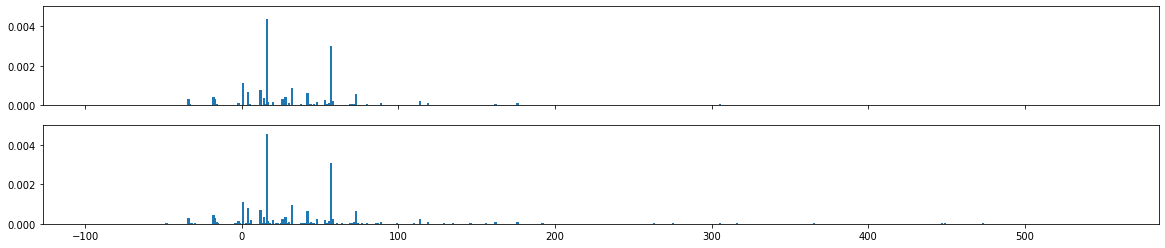

In [259]:
fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, sharey = True, sharex=True)
ax1.bar(x=data.delta_mass, height=data.PSM_count_AD, width=1.4)
ax2.bar(x=data.delta_mass, height=data.PSM_count_Ctrl, width=1.4)
# sns.barplot(ax = axes[0], data=data, x="delta_mass", y="PSM_count_H2O2")
# sns.barplot(ax = axes[1], data=data, x="delta_mass", y="PSM_count_Control")

fig.set_size_inches(20,4)
plt.ylim(0,0.005)

plt.show()

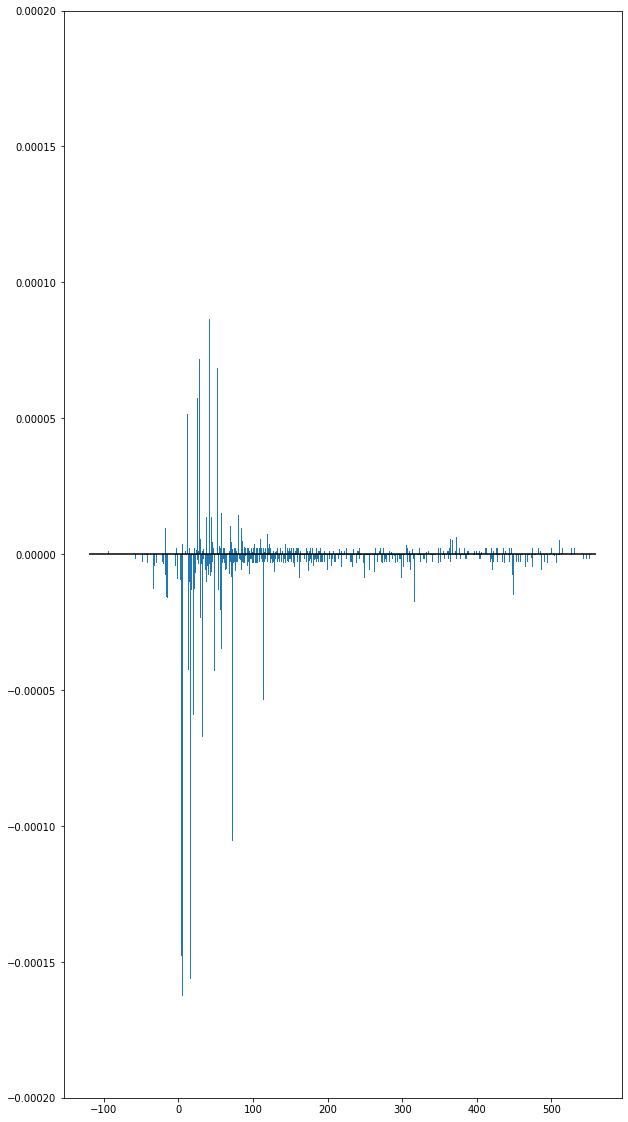

In [261]:
fig, ax = plt.subplots()
# sns.barplot(ax = ax, data=data, x="delta_mass", y="Difference")

ax.bar(x=data.delta_mass, height=data.Difference, width=1.2)
fig.set_size_inches(10,20)



# ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
plt.hlines(y=0, xmin=-120, xmax=560, colors="k")
plt.ylim(-0.0002,0.0002)
plt.show()

In [262]:
sorted = data.sort_values(by="Difference", axis=0, ascending=False)

In [263]:
sorted.head(10)

,delta_mass,Status_Ctrl,PSM_count_Ctrl,Status_AD,PSM_count_AD,Difference
146,42.0106,ctrl2,0.000164,AD2,0.000251,0.000086
96,27.9949,ctrl2,0.000358,AD2,0.000430,0.000072
176,52.9115,ctrl2,0.000194,AD2,0.000263,0.000069
90,26.0157,ctrl2,0.000244,AD2,0.000301,0.000057
53,12.0000,ctrl2,0.000717,AD2,0.000768,0.000051
97,28.0313,ctrl2,0.000149,AD2,0.000173,0.000024
149,42.0470,ctrl2,0.000623,AD2,0.000640,0.000017
197,58.0055,ctrl2,0.000221,AD2,0.000236,0.000015
283,79.9663,ctrl2,0.000059,AD2,0.000074,0.000014
131,37.9559,ctrl2,0.000033,AD2,0.000046,0.000014


42.010565 : Acetylation

27.9949: Formylation	

52.9115: Replacement of 3 protons by iron	

26.0157 : Acetaldehyde +26	

12: formaldehyde adduct	

28.0313: Acetaldehyde +28	

42.0470: tri-Methylation	

58.0055 : Carboxymethyl

79.9663: Phosphorylation

37.9559	: Replacement of proton by potassium	



In [264]:
sorted.tail(10)

,delta_mass,Status_Ctrl,PSM_count_Ctrl,Status_AD,PSM_count_AD,Difference
60,13.9793,ctrl2,0.000201,AD2,0.000158,-0.000043
167,47.9847,ctrl2,0.000222,AD2,0.000179,-0.000043
196,57.0215,ctrl2,0.003060,AD2,0.003012,-0.000049
402,114.0430,ctrl2,0.000245,AD2,0.000191,-0.000054
79,19.9898,ctrl2,0.000212,AD2,0.000153,-0.000059
112,31.9898,ctrl2,0.000949,AD2,0.000882,-0.000067
255,73.0164,ctrl2,0.000656,AD2,0.000550,-0.000105
47,3.9949,ctrl2,0.000793,AD2,0.000645,-0.000148
69,15.9949,ctrl2,0.004542,AD2,0.004386,-0.000156
50,6.0082,ctrl2,0.000176,AD2,0.000013,-0.000162


6.0082: Proton replacement by lithium

15.9949: Oxidation

3.9949: tryptophan oxidation to kynurenin	

73.0164: Oxidation + Carbamidomethyl

31.9898: Dioxidation

19.9898: tryptophan oxidation to hydroxykynurenin	

114.0430: Ubiquitination

57.0215: Carbamidomethyl

47.9847: Trioxidation

13.9793: Carbonylation